# Least Squares Regression for Impedance Analysis

![](spectrumTest.png)

## Introduction
This is a tutorial for how to set up the functions and calls for curve fitting
an experimental impedance spectrum with Python using a least squares
regression.  Four different models are used as examples for how to set up the
curve fit and estimate parameters. The first two are generic circuit element
combinations, to illustrate the input-output flow of the functions, the third
example is of a Randles circuit, which can be used for parameter estimation and
finally the Macrohomogeneous Porous Electrode (MHPE).

## Contents

  * [Nomenclature](#Nomenclature)
  * [Modules](#Modules)
  * [Functions](#Functions)
    * [Impedance Models](#Impedance-Models)
        * [z_a](#z_a) - Equivalent circuit example 1
            * [Inputs](#z_a-Inputs)
            * [Outputs](#z_a-Outputs)
            * [Example function call](#Example-Usage-of-z_a)
        * [z_b](#z_b) - Equivalent circuit example 2
            * [Inputs](#z_b-Inputs)
            * [Outputs](#z_b-Outputs)
            * [Example function call](#Example-Usage-of-z_b)
        * [Randles Circuit](#Randles-Circuit)
          * [warburg](#warburg)
              * [Inputs](#warburg-Inptus)
              * [Outputs](#warburg-Outputs)
          * [z_randles](#z_randles)
              * [Inputs](#z_randles-Inptus)
              * [Outputs](#z_randles-Outputs)
        * [z_mhpe (Macrohomogeneous Porous Electrode](#z_mhpe)
            * [Inputs](#z_mhpe-Inputs)
            * [Outputs](#z_mhpe-Outputs)
        * [cell_response](#cell_response)
            * [Inputs](#cell_response-Inptus)
            * [Outputs](#cell_response-Outputs)
            * [Example function call](#Example-usage-of-cell_response)
    * [Least Squares](#Least-Squares)
        * [residual](#residual)
          * [Inputs](#residual-Inptus)
          * [Outputs](#residual-Outputs)
          * [Example function call](#Example-usage-of-residual)
        * [z_fit](#z_fit)
    * [z_plot](#z_plot)
  * [Example Function Calls](#Examples) - examples of the input - output syntax of functions
  * [Experimental Data](#Experimental-Data) - these are the data used in the curve fitting examples
  * [Curve Fitting Examples](#Curve-Fitting-Examples)
    * [Comparison of z_a and z_b](#Example-fitting-a-spectrum-(z_a-and-z_b))
    * [Randles Circuit](#Example-fitting-a-spectrum-(z_randles))
    * [Macrohomogeneous Porous Electrode](#Example-fitting-a-spectrum-(z_mhpe))
  * [Appendix](#Appendix)

## Nomenclature

|Parameter | Description |Unit |
|---- |---- |---- |
|$A$ | Geometric surface area| $cm^2$|
|$ASR_x$ | Area Specific Resistance of x | $\Omega\ cm^2$|
|$A_t$ | Wetted surface area | $cm^2$|
|$CPE$ | Constant Phase Element| $F^P$|
|$C_x$ | Concentration of species x| $mol\ cm^{-3}$|
|$D_x$ | Diffusivity of species x| $cm^{2}\ s^{-1}$|
|$F$ | Faraday's constant| $C\ mol^{-1}$|
|$L$ | Inductance| $H$|
|$P$ | CPE exponent| $-$|
|$Q$ | CPE parameter| $F$|
|$R$ | Universal gas constant| $J\ mol^{-1}\ K^{-1}$|
|$T$ | Temperature| $K$|
|$W$ | Warburg impedance| $\Omega$|
|$Z_{x}$ | Impedance of x| $\Omega$|
|$a$ | Nernstian diffusion layer thickness| $cm$|
|$b$ | electrode thickness| $cm$|
|$f$ | Scale factor| $-$|
|$g_{ct}$ | charge transfer conductance (per unit length) | $S cm^{-1}$|
|$i_0$ | Exchange current density| $A\ cm^{-2}$|
|$j$ | Imaginary unit ($\sqrt{-1}$)| $-$|
|$n$ | Number of electrons transferred| $-$|
|$\lambda$ | complex decay length| cm |
|$\omega$ | Angular frequency| $rad\ s^{-1}$|
|$\rho_1$ | Electrolyte resistivity| $\Omega\ cm$|
|$\rho_2$ | Solid Phase resistivity| $\Omega\ cm$|

### Modules
The three modules used in this tutorial are [numpy](https://numpy.org/),
[scipy](https://www.scipy.org/), and [matplotlib](https://matplotlib.org/).
These can be installed from the shell (not iPython) with the following command:

    pip install numpy scipy matplotlib
    
They are imported into the scope of the program with the following commands:

[Link to Contents](#Contents)

In [84]:
from numpy import real,imag,pi,inf,array,concatenate,log,logspace,tanh,sqrt,exp,sinh
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import matplotlib
#------------------------------------------------------------------------------
# Constants
F = 96485.33289
Ru = 8.3144598
#------------------------------------------------------------------------------
try:
    plt.style.use("jupyter_style")
except:
    plt.rcParams['axes.labelsize'] = 24
    plt.rcParams['font.size'] = 20
fs = (12,6)     # figure size
coth = lambda x: (exp(2*x)+1)/(exp(2*x)-1)
colors = 'rgbcmyk'
markers = 'x+v^os'

# Functions

## Impedance Models

Each of the impedance models adhere to the following function template:
  * Inputs:
      * input_dict - *dictionary* containing the model parameters. There is no distinction from the perspective of the model (function) between fitted and fixed parameters.  This is handled by the least_squares functions and allows the user to define which parameters should float and which should be fixed.
      * frequency - a frequency **or** an (numpy) *array* of frequencies at which to evaluate the model
  * Output:
      * Z($\omega$) - (complex number)

[Link to Contents](#Contents)

---

### z_a

*z_a* is a function which **returns** the complex impedance response of the following equivalent circuit model.

                          
![](circuit_element/z_a.png)


The equation for this circuit is:

$$z_a = R_0 + (R_1^{-1} + j \omega C_1)^{-1} + (R_2^{-1} + j\omega C_2)^{-1} $$

#### z_a Inputs

  * a dictionary containing the parameters (indexed by keys that match the variable names) in the model:
    0. 'R0' - Resistance 0 (ohmic resistance)
    1. 'R1' - Resistance 1
    2. 'R2' - Resistance 2 
    3. 'C1' - capacitance 1 (in parallel with R1)
    4. 'C2' - capacitance 2 (in parallel with R2)
  * frequency - frequency (or array of frequencies) to calculate impedance (rad / sec)

#### z_a Outputs

  * Z($\omega$) - (complex number)

[Link to Contents](#Contents)

In [85]:
def z_a(input_dict,
        frequency):
    R0 = input_dict['R0']
    R1 = input_dict['R1']
    R2 = input_dict['R2']
    C1 = input_dict['C1']
    C2 = input_dict['C2']
    return(R0+(R1**-1+1j*frequency*C1)**-1+(R2**-1+1j*frequency*C2)**-1)

### z_b

*z_b* is a function which **returns** the complex impedance response of the
following equivalent circuit model.


![](circuit_element/z_b.png)

The equation for this circuit is:

$$z_b = R_0 + ((R_1 + (R_2^{-1} + j\omega C_2)^{-1})^{-1} + j \omega C_1)^{-1} $$

#### z_b Inputs

  * a dictionary containing the parameters (indexed by keys that match the variable names) in the model:
    0. 'R0' - Resistance 0 (ohmic resistance)
    1. 'R1' - Resistance 1
    2. 'R2' - Resistance 2
    3. 'C1' - capacitance 1 (in parallel with R1 and the parallel combination of R2 and C2)
    4. 'C2' - capacitance 2 (in parallel with R2)
  * frequency - frequency (or array of frequencies) to calculate impedance (rad / sec)

#### z_b Outputs

  * Z($\omega$) - (complex number)

[Link to Contents](#Contents)

In [86]:
def z_b(input_dict,
        frequency):
    R0 = input_dict['R0']
    R1 = input_dict['R1']
    R2 = input_dict['R2']
    C1 = input_dict['C1']
    C2 = input_dict['C2']
    return(R0+1/(1/(R1+1/(1/R2+(1j*frequency)*C2))+(1j*frequency)*C1))

### Randles Circuit

The following functions set up the calculations for a Randles circuit response.
This is broken up into two functions:

  * [warburg](#warburg)
  * [z_randles](#z_randles)

Breaking the solution process up in this way helps the readability of the
functions and the process of decomposing circuit elements.  Note that each of
these functions take the same arguments and follow the template described
[here](#Impedance-models). Using dictionaries (instead of lists/arrays) allows
for the arguments to these functions to be generic so that they can extract the
values that they need without needing inputs to be ordered, which allows for
higher flexibility. [z_randles](#z_randles) is called by the function
[cell_response](#cell_response) to determine the response of the symmetric cell.

[Link to Contents](#Contents)

### warburg

The Warburg element is modeled by:

$$\frac{W}{A} = \frac{RT}{A_tn^2F^2C_RfD_R}\frac{tanh\bigg(a\sqrt{\frac{j\omega}{D_R}}\bigg)}{\sqrt{\frac{j\omega}{D_R}} }+\frac{RT}{A_tn^2F^2C_OfD_O}\frac{tanh\bigg(a\sqrt{\frac{j\omega}{D_O}}\bigg)}{\sqrt{\frac{j\omega}{D_O} }}$$

#### warburg Inputs

  * *input_dict*: a dictionary containing all the parameters for the full cell response, the warburge element only needs the entries for:
    * 'T'
    * 'C_R'
    * 'C_O'
    * 'D_R'
    * 'D_O'
    * 'n'
    * 'A_t'
    * 'a'
    * 'f'

  * frequency - frequency to calculate impedance (rad / sec)

#### warburg Outputs
  * W($\omega$) - (complex number)

[Link to Contents](#Contents)

In [87]:
def warburg(input_dict,
            frequency):
    T = input_dict['T']
    A_t = input_dict['A_t']
    C_R = input_dict['C_R']
    C_O = input_dict['C_O']
    D_R = input_dict['D_R']
    D_O = input_dict['D_O']
    n = input_dict['n']
    a = input_dict['a']
    f = input_dict['f']
    c1 = (Ru*T)/(A_t*n**2*F**2*f)             # both terms multiply c1
    term1 = c1*tanh(a*sqrt(1j*frequency/D_R))/(C_R*sqrt(D_R*1j*frequency))
    term2 = c1*tanh(a*sqrt(1j*frequency/D_O))/(C_O*sqrt(D_O*1j*frequency))
    return(term1+term2)

### z_randles

z_randles calculates the response of a randles circuit element with no ohmic
resistance (complex number). It calls [warburg](#warburg) and returns the
serial combination of the charge transfer resistance and the warburg impedance
in parallel with a constant phase element (CPE).


![](circuit_element/z_randles.png)


This is modeled by the equation:

$$Z_{Randles} = A \times (z_{ct}^{-1}+j\omega^{P}Q)^{-1}$$ 

The charge transfer impedance is modeled by the equation:

$$z_{ct} = R_{ct} + W $$

Where the charge transfer resistance is calculated by the equation:

$$R_{ct} = \frac{RT}{A_tnFi_0}$$

The term $\frac{1}{j\omega^PQ}$ represents the CPE.

#### z_randles Inputs

  * *input_dict*: a dictionary containing all the parameters for the full cell response, z_randles only needs the entries for:
    * 'T'
    * 'n'
    * 'A_t'
    * 'i0'

  * frequency - frequency to calculate impedance (rad / sec)

#### z_randles Outputs

  * Z_ct($\omega$) / ($\Omega$ cm$^2$) - (complex number)

[Link to Contents](#Contents)

In [88]:
def z_randles(  input_dict,
                frequency):
    T = input_dict['T']
    n = input_dict['n']
    A_t = input_dict['A_t']
    i0 = input_dict['i0']
    P = input_dict['P']
    C_dl = input_dict['C_dl']
    A = input_dict['A']
    # Calculate Warburg Impedance
    w = warburg(input_dict,frequency)
    # Calculate charge transfer resistance
    R_ct = Ru*T/(n*F*i0*A_t)
    serial = R_ct+w
    z_ct = 1/(1/serial+(1j*frequency)**P*C_dl*A_t)
    return(A*z_ct)

### z_mhpe

*z_mhpe* calculates the response of the macrohomogeneous porous electrode model
to the specified inputs.  Note that this function calls [z_randles](#z_randles)
to to determine the Randles circuit response.  The derivation of this circuit
element is equivalent to a branched transmission line with Randles circuit
elements defining the interfacial interaction. Which interact with different
amounts of electrolyte resistivity determined by the electrode thickness.  

![](circuit_element/mhpe.png)

This model was derived by Paasch *et al.* and has several equivalent
formulations:

Equation 22 from [Paasch *et al.*](https://doi.org/10.1016/0013-4686(93)85083-B)
$$ AZ_{mhpe} = \frac{(\rho_1^2+\rho_2^2)}{(\rho_1+\rho_2)}\frac{ coth(b \beta)}{\beta}
+ \frac{2\rho_1 \rho_2 }{(\rho_1+\rho_2)}\frac{1}{\beta sinh(b \beta)}
+ \frac{\rho_1 \rho_2 b}{(\rho_1+\rho_2)}$$

Equation 10 from [Nguyen *et al.*](https://doi.org/10.1016/S0022-0728(98)00343-X)
$$ Z_{mhpe} \frac{A}{b} = \frac{(\rho_1^2+\rho_2^2)}{(\rho_1+\rho_2)}\frac{\lambda}{b} coth\bigg(\frac{b}{\lambda}\bigg)
+ \frac{2\rho_1 \rho_2 }{(\rho_1+\rho_2)}\frac{\lambda}{b}\bigg(sinh\bigg(\frac{b}{\lambda}\bigg)\bigg)^{-1}
+ \frac{\rho_1 \rho_2 b}{(\rho_1+\rho_2)}$$

Equation 1 from [Sun *et al.*](https://www.osti.gov/biblio/1133556-resolving-losses-negative-electrode-all-vanadium-redox-flow-batteries-using-electrochemical-impedance-spectroscopy)
$$ A Z_{mhpe} = \frac{(\rho_1^2+\rho_2^2) b}{(\rho_1+\rho_2)}\frac{coth(Q_2)}{Q_2}
+ \frac{2\rho_1 \rho_2 b}{(\rho_1+\rho_2)Q_2sinh(Q_2)}
+ \frac{\rho_1 \rho_2 b}{(\rho_1+\rho_2)}$$

Clearly if these are equivalent then:

$$ b\beta = \frac{b}{\lambda} = Q_2$$

#### z_mhpe Inputs

  * *input_dict*: a dictionary containing all the parameters for the, MHPE
    response :
    * 'rho1'
    * 'rho2' - $\frac{\rho_{ 2}^*f_p}{\nu_p}$ (page 2654) where $\rho_2$ = bulk electrolyte resistivity, $f_p$  is the toruosity factor and $\nu_p$ is the relative pore volume
    * 'b'

  * frequency - frequency to calculate impedance (rad / sec)

#### z_mhpe Outputs

  * AZ_mhpe ($\omega$) / ($\Omega$ cm$^2$) - (complex number)

[Link to Contents](#Contents)

In [89]:
def z_mhpe( input_dict,
            frequency):
    rho1 = input_dict['rho1']
    rho2 = input_dict['rho2']
    b = input_dict['b']
    C_dl = input_dict['C_dl']
    A_t = input_dict['A_t']
    A = input_dict['A']
    T = input_dict['T']
    n = input_dict['n']
    i0 = input_dict['i0']
    P = input_dict['P']
    

    # these are the same for each formulation of the MHPE model
    coeff_1 = (rho1**2+rho2**2)/(rho1+rho2)
    coeff_2 = 2*rho1*rho2/(rho1+rho2)
    term_3 = rho1*rho2*b/(rho1+rho2)

    ##=========================================================================
    ## Sun et al. 2014
    ##-------------------------------------------------------------------------
    ## note: z_r multiplies the response by A/At so this operation is already
    ## finished for equation 2
    ##-------------------------------------------------------------------------
    #z_r = z_randles(input_dict,frequency)               # equation 6
    #Q2 = sqrt((rho1+rho2)*b/z_r)                        # equation 2
    #term_1 = coeff_1*(b/Q2)*coth(Q2)
    #term_2 = coeff_2*(b/Q2)*sinh(Q2)**(-1)
    ##=========================================================================
    ##  Paasch et al. '93
    ##--------------------------------------------------------------------------
    ## note: modification of g_ct (below equation 9) to include mass transfer
    ## conductance  (on unit length basis) - recall that the warburg element
    ## already has A_t  in its denominator so it is only multiplied by b to
    ## account for the fact that it has A*S_c in its denominator
    ##--------------------------------------------------------------------------
    #S_c = A_t/(b*A)                                     # below equation 2
    #C_1 = A*S_c*C_dl                                    # equation 3
    #g_ct = 1/(Ru*T/(n*F*i0*S_c*A) + b*warburg(input_dict,frequency))
    #k = g_ct/C_1                                        # equation 12
    #K = 1/(C_dl*S_c*(rho1+rho2))                        # equation 12
    #omega_1 = K/b**2                                    # equation 23
    #beta = (1/b)*((k+(1j*frequency)**P)/omega_1)**(1/2) # equation 23
    #term_1 = coeff_1*(coth(b*beta)/beta)
    #term_2 = coeff_2*(1/beta)*sinh(b*beta)**(-1)
    ##=========================================================================
    # Nguyen et al.
    #--------------------------------------------------------------------------
    # note: Paasch was a co-author and it uses much of the same notation as '93
    # They use a mass transfer hindrance term instead of warburg, so it is
    # replaced again here like it was for the Paasch solution. Also notice that
    # omega_0 is equivalent to k in Paasch et al.
    # the warburg element function returns W with A_t already in the
    # denominator, so it is multiplied by b to account for the fact that it has
    # S_c*A in its denominator
    #--------------------------------------------------------------------------
    S_c = A_t/(b*A)                                     # below equation 4
    g_ct = 1/(Ru*T/(n*F*i0*S_c*A) + b*warburg(input_dict,frequency))
    omega_0 = g_ct/(C_dl*S_c*A)                         # equation 6
    g = C_dl*S_c*((1j*frequency)**P+omega_0)            # equation 5
    lamb = 1/sqrt(g*(rho1+rho2))                        # equation 4
    term_1 = coeff_1*lamb*coth(b/lamb)
    term_2 = coeff_2*lamb*(sinh(b/lamb))**(-1)

    #--------------------------------------------------------------------------
    mhpe = term_1+term_2+term_3
    return(mhpe)

### cell_response

*cell_response* calculates the Randles circuit response of a symmetric cell, which is illustrated graphically in the following circuit model.

![](circuit_element/symmetric_cell.png)
                  
The symmetric cell is assumed to contribute equally with both half-cells which
necessitates the $\times 2$.  The following equation models this response:

$$\frac{Z_{Randles}}{A} = R_{mem} + j \omega L + 2 \times z_{electrode}$$ 

Where

$$z_{electrode} \in [z_{randles},z_{mhpe}]$$

#### cell_response Inputs

  * *input_dict*: a dictionary containing all the parameters for the full cell response, z_randles only needs the entries for:
    * 'A'
    * 'C_dl'
    * 'A_t'
    * 'P'
    * 'ASR_mem'
    * 'L'

  * frequency - frequency to calculate impedance (rad / sec)

#### cell_response Outputs

  * AZ_randles$($\omega$) - (complex number)

[Link to Contents](#Contents)

In [90]:
def cell_response(  input_dict,
                    frequency):
    A = input_dict['A']
    ASR_mem = input_dict['ASR_mem']
    L = input_dict['L']
    z_model = input_dict['z_model']     # z_model can be z_randles or z_mhpe
    z_elec = z_model(input_dict,frequency)
    return(ASR_mem+2*z_elec+1j*L*frequency*A)

## Least Squares

This script uses
[scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html).
To optimize the parameters.  The two functions defined here are the *residual*
calculation and the fitting function *z_fit* which facilitates the I/O for the
least_squares with different models.

[Link to Contents](#Contents)

### *residual*
*residual* is a function which is an input to scipy.optimize.least_squares.
It calculates the impedance response at a given frequency (or range of
frequencies) and returns the difference between the generated value(s) and the
experimental data.

#### *residual* Inputs
  * x0 - a list, which stores the arguments that are inputs to *Z*. The
    parameters are unpacked in the following order:
  * frequency - frequency argument to *Z* (can be single value or array)
  * data - experimental data (complex number)
  * input_dict - a dictionary which contains at the minimum the values that the selected model expects
  * floating_params - *list* which contains the keys (which are entries in input_dict) for the floating parameters
  * model - for the impedance models described in this tutorial, each has a
    template format with 3 arguments. For this reason, they can be treated as
    arguments to *residual* and can be used interchangeably.

#### *residual* Outputs

  * 1D array (real numbers) with difference (at each frequency) between experimental and simulated spectrum

[Link to Contents](#Contents)

In [91]:
def residual(   x0,
                frequency,
                data,
                input_dict,
                floating_params,
                model):
    # the dictionary (temp_dict) is the interface between the residual calculation and the
    # models, by having the residual seed temp_dict with the floating
    # parameters, the level of abstraction given to ability of parameters to
    # float is increased. (not all of the models will need the same format and
    # they can parse dictionaries for values they are expecting)
    temp_dict = {}
    for i,key in enumerate(floating_params):
        temp_dict[key] = x0[i]
    for key in input_dict:
        if key not in floating_params:
            temp_dict[key] = input_dict[key]

    # generate a spectrum with the inputs
    Z_ = model( temp_dict,frequency)
    # Calculate the difference between the newly generated spectrum and the
    # experimental data
    Real = real(Z_)-real(data)
    Imag = imag(Z_)-imag(data)
    return(concatenate([Real,Imag]))

### *z_fit*

*z_fit* sets up the call to
[scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)
and returns the fitted parameters

#### *z_fit* Inputs
  * inputDict - a dictionary which contains the initial guess for the parameters. 
  * residualFunction - residual to be minimized by least_squares
  * ReZ - real component of complex impedance ($\Omega$)
  * ImZ - imaginary component of complex impedance ($\Omega$)
  * frequency - array with same dimensions as ReZ and ImZ (rad s$^{-1}$)
  * area - geometric surface area (cm$^2$)
  * model - both z_a and z_b are valid input arguments as the model for Zfit to use.
  * constants - fixed parameters for the model
  * oneMaxKeys - *optional* - a list containing any parameters that have a maximum value of 1 (i.e. CPE exponent P)

*z_fit* converts the input data from individual ReZ and ImZ arrays of
resistances (in $\Omega$) to complex impedance values in ASR ($\Omega$ cm$^2$).
The bounds_lower and bounds_upper variables set the bounds for the parameters
(i.e.  non-negative for this case). **Note**: The order of the arguments in
bounds_lower and bounds_upper is the same as the order of x0 and correspond to
parameters which share the same index.

The default method for least_squares is *Trust Region Reflective* ('trf'),
which is well suited for this case.  The variable *out* contains the output of
the call to least_squares.

[Link to Contents](#Contents)

In [92]:
def z_fit(  input_dict,
            ReZ,
            ImZ,
            frequency,
            floating_params,
            area,
            model,
            residual_function,
            one_max_keys = []):
    # parameter order -> [R0, R1, R2, C1, C2]
    data = (ReZ-1j*ImZ)*area
    # Set the bounds for the parameters
    x0 = [input_dict[key] for key in floating_params]
    bounds_lower = [0 for key in floating_params]
    bounds_upper = [inf if param not in one_max_keys else 1 for param in floating_params]
    out = least_squares(   residual_function,
                           x0,
                           bounds = (bounds_lower,bounds_upper),
                           args = (frequency,data,input_dict,floating_params,model))

    output_dict = {}
    j = 0
    print("-"*80)
    print("model = {}".format(input_dict['z_model'].__name__))
    for key in floating_params:
        output_dict[key] = out.x[j]
        print("\t{} = {}".format(key,out.x[j]))
        j+=1
    for key in input_dict:
        if key not in floating_params:
            output_dict[key] = input_dict[key]
    # the fitted parameters are extracted from the 'output' variable
    return(output_dict)

### z_plot

*z_plot* is a function used to generate plots of the spectra (both
experiment and model). It creates a subplot with two columns: the first column
is an Argand diagram (Nyquist plot) comparing the experimetn and model; the
second column compares the spectra (real and imaginary components) as a function
of frequency.

#### *z_plot* Inputs

  * ReZ - Real(Z) of a spectrum
  * ImZ - Imaginary(Z) of a spectrum
  * ax_1 - handle for axis with nyquist plot
  * ax_2 - handle for axis with frequency plot
  * label - label the curves on each axis
  * color - *optional* - list of colors to be used
  * marker - *optional* - list of markers to be used
  * linestyle - *optional* - linestyle specifier
  * resistances - (list) contains the intercepts with the real axis

[Link to Contents](#Contents)

In [93]:
def z_plot(ReZ,
          ImZ,
          frequency,
          ax_1,
          ax_2,
          label,
          color = ['k','k'],
          marker = ['x','+'],
          linestyle = '',
          resistances = []):
    # Nyquist plot for the spectrum
    ax_1.plot(ReZ,-ImZ,color = color[0], marker = marker[0], 
                    linestyle = linestyle, label = label)
    # plotting the real axis intercepts
    if resistances != []:
        R0,R1,R2 = resistances
        ax_1.plot(R0,0,'b+')
        ax_1.plot(R0+R1,0,'b+')
        ax_1.plot(R0+R1+R2,0,'b+',label = 'model ASR estimation')
    ax_1.axis('equal')
    ax_1.set_xlabel('Re(Z) / $\Omega$ cm$^2$')
    ax_1.set_ylabel('-Im(Z) / $\Omega$ cm$^2$')
    # |Z| as a function of frequency 
    ax_2.plot(log(frequency),-ImZ,color = color[0], marker = marker[0], 
                    label = "-Im({})".format(label), linestyle = linestyle)
    ax_2.plot(log(frequency),ReZ,color = color[1], marker = marker[1], 
                    label = "Re({})".format(label), linestyle = linestyle)
    ax_2.set_xlabel('log(frequency) / rad s$^{-1}$')
    ax_2.set_ylabel('|Z| / $\Omega$ cm$^2$')
    ax_2.yaxis.set_label_position('right')
    [ax.legend(loc = 'best') for ax in [ax_1,ax_2]]

### high_frequency_detail

*high_frequency_detail* 

#### *high_frequency_detail* Inputs

  * ReZ - Real(Z) of a spectrum
  * ImZ - Imaginary(Z) of a spectrum
  * ax - handle for axis for nyquist plot
  * label - label the curves on each axis
  * color - *optional* - string with color
  * marker - *optional* - string with marker to be used
  * linestyle - *optional* - linestyle specifier
  * spacing - *optional* - how wide and tall the window will be
  * xlim - *optional* - list containing x limits for plot
  * ylim - *optional* - list containing y limits for plot

[Link to Contents](#Contents)

In [94]:
def high_frequency_detail(  ReZ,
                            ImZ,
                            ax,
                            label,
                            color = 'k',
                            marker = 'x',
                            linestyle = '',
                            spacing = 2,
                            x_min = 0,
                            y_min = 0):
    ax.plot(    ReZ,ImZ,
                color = color,
                marker = marker,
                label = label,
                linestyle = linestyle)
    ax.set_ylim(y_min,y_min+spacing)
    ax.set_xlim(x_min,x_min+spacing)
    ax.set_xlabel('Re(Z) / $\Omega$ cm$^2$')
    ax.set_ylabel('-Im(Z) / $\Omega$ cm$^2$')

## Examples

The following are examples demonstrating the  I/O for the functions.  These are
the *forward* calculations of spectra (i.e. the parameters are knowns). 
[Here](#Curve-Fitting-Examples) is a link to the examples for curve fitting the
experimental data.

[Link to Contents](#Contents)

### Example Usage of z_a

[Link to Contents](#Contents)

(3.399992000032-0.803999984000064j)


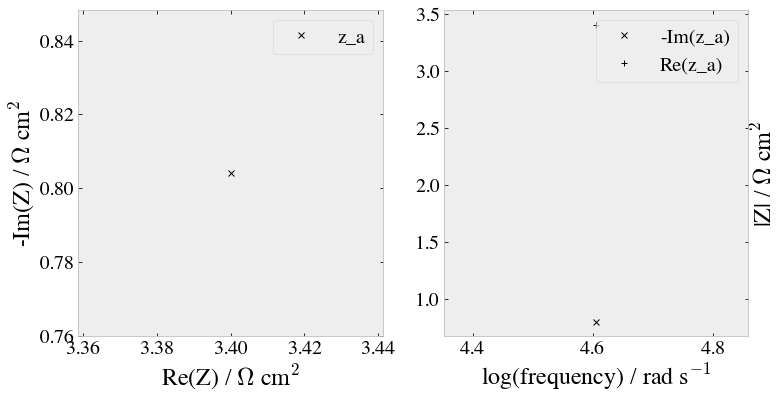

In [104]:
input_dict = {
            'R0':1,
            'R1':2,
            'R2':2,
            'C1':10e-6,
            'C2':10e-3,
            'z_model':z_a
            }
fre = 100
# uncomment the following line to use a numpy array as an input to z_a
#fre = logspace(-1,6,60)
z_ = z_a(input_dict,fre)
print(z_)
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = fs, num = 0)
z_plot(real(z_),imag(z_),fre,ax[0],ax[1],'z_a')

### Example Usage of *z_b*

[Link to Contents](#Contents)

(3.3961508233174227-0.8051066766346542j)


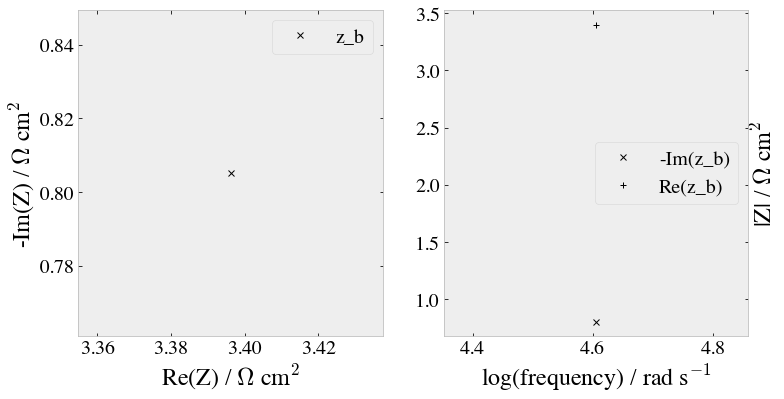

In [96]:
input_dict = {
            'R0':1,
            'R1':2,
            'R2':2,
            'C1':10e-6,
            'C2':10e-3,
            'z_model':z_b
            }
fre = 100
# uncomment the following line to use a numpy array as an input to z_b
#fre = logspace(-1,6,60)
z_ = z_b(input_dict,fre)
print(z_)
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = fs, num = 1)
z_plot(real(z_),imag(z_),fre,ax[0],ax[1],'z_b')

### Example usage of cell_response

[Link to Contents](#Contents)

--------------------------------------------------------------------------------
Model name =  z_randles
(9.186872559440204-1.5647715881589044j)
--------------------------------------------------------------------------------
Model name =  z_mhpe
(9.50704105883616-1.565169355121878j)


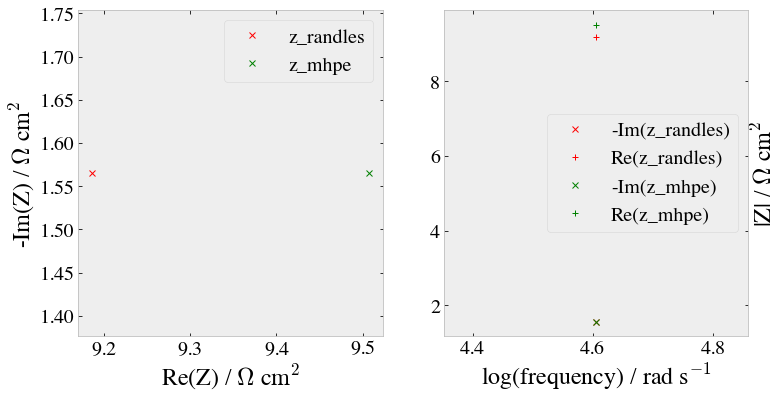

In [103]:
# Example Usage of cell_response
input_dict = {
        'T':303.15,     # Temperature (K)
        'A':5,          # geometric surface area (cm^2)
        'C_R':0.00025,  # concentration of reduced species (mol / L)
        'C_O':0.00025,  # concentration of oxidized species (mol / L)
        'rho1':1.6,     # electrolyte resistivity (ohm cm^-1)
        'rho2':.012,    # solid phase resistivity (ohm cm^-1)
        'b':.3,         # electrode thickness (cm)
        'D_R':1.1e-6,   # Diffusion coefficient for reduced species (cm^2 / s)
        'D_O':0.57e-6,  # Diffusion coefficient for oxidized species (cm^2 / s)
        'C_dl':20e-6,   # Double layer capacitance per unit surface area
        'n':1,          # number of electrons transferred
        'A_t':100,      # Wetted surface area (cm^2)
        'i0':3e-4,      # exchange current density (A cm^2)
        'P':.95,        # CPE exponent (-)
        'ASR_mem':.5,   # membrane ASR (Ohm cm^2)
        'a':.002,       # Nernstian diffusion layer thickness (cm)
        'f':.05,        # scale factor (-)
        'L':1e-7,       # inductance (H)
        }
fre     = 100       # frequency to evaluate (rad / s)
#---------------------------------------------------------------------------
# uncomment the following line to use a numpy array as an input to Z_Randles
#---------------------------------------------------------------------------
#fre = logspace(-1,6,60)
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = fs, num = 2)
for j,model in enumerate([z_randles,z_mhpe]):
    input_dict['z_model'] = model
    print("-"*80)
    print("Model name = ",model.__name__)
    z_ = cell_response(input_dict,fre)
    print(z_)
    z_plot(real(z_),imag(z_), fre,
             ax[0],
             ax[1],
             model.__name__,
             color = [colors[j]]*2)

### Example usage of *residual*

**Note**: *residual* is only used in the scope
of [*z_fit*](#z_fit) as an argument for *scipy.optimize.least_squares*.  This is
simply to illustrate the way it is called.

In [98]:
input_dict = {
            'R0':1,
            'R1':2,
            'R2':2,
            'C1':10e-6,
            'C2':10e-6,
            'z_model':'z_a'
            }

floating_params = list(input_dict.keys())
x0 = [input_dict[key] for key in input_dict]
area  = 5
# artificial data point and frequency
Zexperimental = (2-1j*.3)*area       
freExperimental = 10
# using model z_a for this example
model = z_a
print(residual(   x0,
                  array([freExperimental]),
                  array([Zexperimental]),
                  input_dict,
                  floating_params,
                  model)
    )

[-5.00000016  1.4992    ]


## Experimental Data

  * 0.5 M V
  * 50% SoC (Anolyte)
  * Untreated GFD3 Electrode
  * 5 cm$^2$ flow through (4 cm $\times$ 1.25 cm)
  * Symmetric Cell
  * 30$^o$ C
  * 25 mL min$^{-1}$
  * 5 mV amplitude
  * 50 kHz - 60 mHz (10 points per decade)
  * recorded with a Bio-Logic VSP potentiostat

[Link to Contents](#Contents)

In [99]:
ReZ = array([ 0.08284266, 0.08796988, 0.09247773, 0.09680536, 0.1008338, 0.1046377,
 0.10762515, 0.11097036, 0.11456104, 0.11730141, 0.12102044, 0.12483983,
 0.12752137, 0.13284937, 0.13733491, 0.14415036, 0.15262745, 0.16596687,
 0.18005887, 0.20618707, 0.23595014, 0.28682289, 0.35581028, 0.4261204,
 0.56032306, 0.66784477, 0.80271685, 0.94683707, 1.0815266 , 1.1962512,
 1.3139805, 1.4123734, 1.4371094, 1.4075497, 1.451781 , 1.4999349,
 1.4951819, 1.520785, 1.5343723, 1.5442845, 1.5559914, 1.5715505,
 1.581386, 1.6037546, 1.6127067, 1.6335728, 1.6475986 , 1.6718234,
 1.6902045, 1.7113601, 1.7273785, 1.7500663, 1.7663705 , 1.7867819,
 1.8013573, 1.8191988, 1.83577, 1.8508064, 1.8635432 , 1.8764733 ])

ImZ = array([
 0.01176712, 0.01655927, 0.02027502, 0.02348918, 0.02688588, 0.02939095,
 0.03261841, 0.03675437, 0.04145328, 0.04685605, 0.05258239, 0.06055644,
 0.07127699, 0.08661526, 0.10406214, 0.12678802, 0.15203825, 0.18704301,
 0.2319441, 0.27572113, 0.33624849, 0.39666826, 0.47322401, 0.53811002,
 0.58483958, 0.63875258, 0.66788822, 0.64877927, 0.58104825, 0.54410547,
 0.46816054, 0.39988503, 0.36872765, 0.30746305, 0.26421374, 0.22142638,
 0.18307872, 0.15832621, 0.14938028, 0.14581558, 0.13111286, 0.12468486,
 0.12108799, 0.12532991, 0.12312792, 0.12196486, 0.12405467, 0.12505658,
 0.12438187, 0.12210829, 0.11554052, 0.11543264, 0.11017759, 0.10541131,
 0.0994625, 0.09146828, 0.0852076, 0.0776009, 0.06408801, 0.05852762])

frequency = 2*pi*array([
5.0019516e+04, 3.9687492e+04, 3.1494135e+04, 2.5019525e+04, 1.9843742e+04,
1.5751949e+04, 1.2519524e+04, 9.9218750e+03, 7.8710889e+03, 6.2695298e+03,
5.0195298e+03, 4.0571001e+03, 3.2362456e+03, 2.4807932e+03, 1.9681099e+03,
1.5624999e+03, 1.2403966e+03, 9.8405493e+02, 7.8124994e+02, 6.2019836e+02,
4.9204675e+02, 3.9062488e+02, 3.0970264e+02, 2.4602338e+02, 1.9531244e+02,
1.5485132e+02, 1.2299269e+02, 9.7656219e+01, 7.7504944e+01, 6.1515743e+01,
4.8828110e+01, 3.8771706e+01, 3.0757868e+01, 2.4414059e+01, 1.9385853e+01,
1.5358775e+01, 1.2187985e+01, 9.6689367e+00, 7.6894670e+00, 6.0939932e+00,
4.8344669e+00, 3.8447335e+00, 3.0493746e+00, 2.4172332e+00, 1.9195327e+00,
1.5246876e+00, 1.2086166e+00, 9.5976633e-01, 7.6234382e-01, 6.0430837e-01,
4.7988322e-01, 3.8109747e-01, 3.0215418e-01, 2.3994161e-01, 1.9053015e-01,
1.5107709e-01, 1.1996347e-01, 9.5265076e-02, 7.5513750e-02, 5.9981719e-02])

## Curve Fitting Examples

### Example fitting a spectrum (z_a and z_b)

[Link to Experimental data](#Experimental-Data)

A *for* loop is used to iterate over the impedance models ([z_a](#z_a) and .
Each iteration calculates new values for the resistances and capacitances and
prints their values. A new spectrum (Z_) is generated with a call to each
respective model with the newly fitted parameters. Z_ is then plotted against
the experimental data. The model is shown in both an Argand diagram (Nyquist
plot) and as a function of the frequency.

[Link to Contents](#Contents)

--------------------------------------------------------------------------------
model = z_a
	R0 = 0.6400868461517526
	R1 = 6.981929811812637
	R2 = 1.5286403566670743
	C1 = 0.00018824741811901253
	C2 = 0.12104631403757465


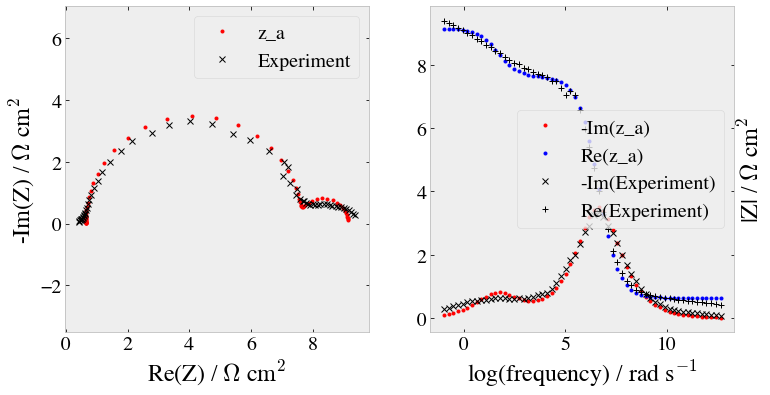

--------------------------------------------------------------------------------
model = z_b
	R0 = 0.6400866900553293
	R1 = 7.003584369228455
	R2 = 1.5069839919882764
	C1 = 0.00018795508290994815
	C2 = 0.12259564229402066


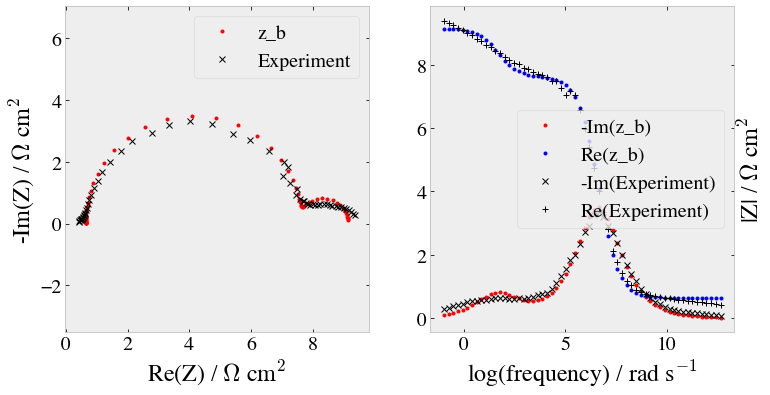

In [100]:
input_dict = {
            'R0':1,
            'R1':2,
            'R2':2,
            'C1':10e-6,
            'C2':10e-6,
            }

floating_params = [key for key in input_dict]
# calculating the fitted parameters with z_fit and printing their values
for i,model in enumerate([z_a,z_b]):
    input_dict['z_model'] = model
    fit_spectrum = z_fit( input_dict,
                                ReZ,
                                ImZ,
                                frequency,
                                floating_params,
                                area,
                                model,
                                residual)
    # generating a new spectrum with fitted parameters
    Z_ = model(fit_spectrum,frequency)
    fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = fs, num = i+3)
    z_plot(real(Z_),imag(Z_),frequency,ax[0],ax[1],model.__name__,color = ['r','b'],marker = ['.','.'])
    z_plot(ReZ*5,-ImZ*5,frequency,ax[0],ax[1],'Experiment',color = ['k','k'],marker = ['x','+'])
    plt.show()

### Comments for z_a and z_b

The models used to fit this spectrum were
chosen arbitrarily as circuits that can model spectra with two semi-circles.
Equivalent circuit models should always be chosen (or formulated) based on the
physics of an electrochemical interface and not on the manifestation of the
interface at the macro level.  Clearly these models have a few limitations:
  * HFR - This experimental spectrum has a small distributed ionic resistance that the model is incapable of capturing.  This can be observed from zooming in the high frequency content of the Nyquist plot, as well as the deviation of Re(z_a) and Re(z_b) from Re(Experiment) in the frequency plot. The result of this is that the membrane resistance will be overestimated.
  * Ambiguity of circuit elements in z_a - Because R1 and R2 are both resistors in parallel with capacitors, there is no guarantee that R1 will correspond with Rct and R2 will correspond with R2.  The starting guesses will determine this and not the interface physics.
  * Constant Phase Element (CPE) - The discrepancy between Im(Z_) and Im(Experiment) in the Nyquist plot can be aided by improved by using a CPE
  * Capacitances in z_a - There is no reason to expect that C1 and C2 would be fully independent
  
The model does, however, give a decent estimate of the chord of the charge transfer resistance and the diffusion resistance with some interpretation of the data.

[Link to Contents](#Contents)

### Example fitting a spectrum (z_randles)

[link to z_randles](#z_randles)

[Link to Contents](#Contents)

--------------------------------------------------------------------------------
model = z_randles
	A_t = 138.07056081826022
	i0 = 0.0002659455683665125
	P = 0.9366233176747505
	ASR_mem = 0.5419474240127952
	a = 0.0007414682478176103
	f = 0.09502889403088155
	L = 1.882225456401995e-40


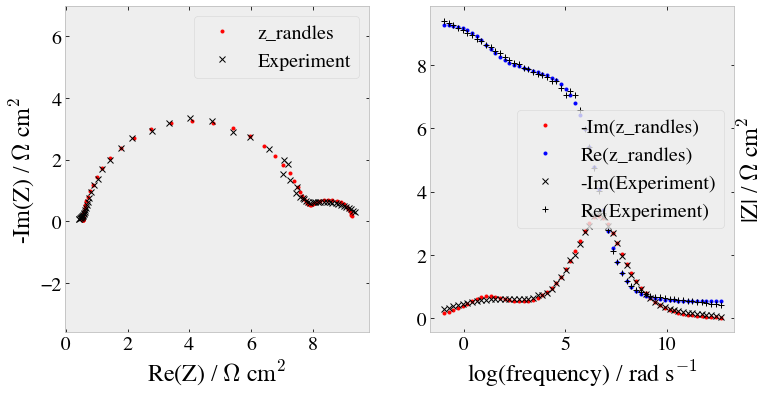

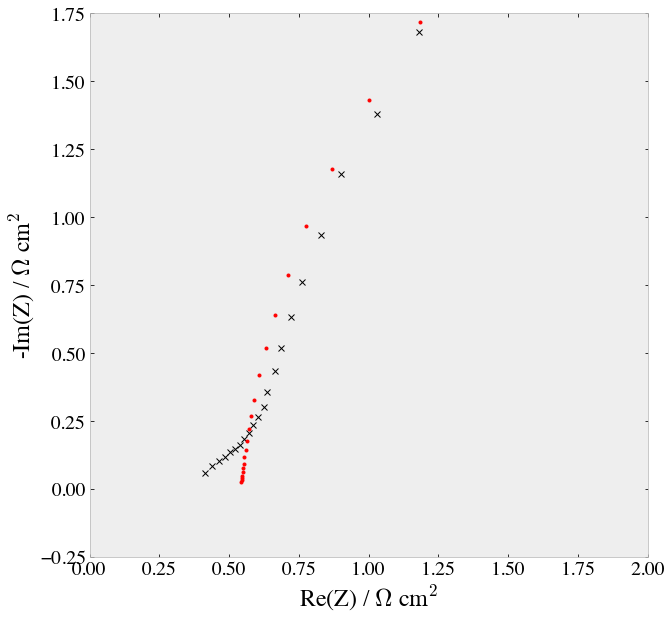

In [101]:
input_dict = {
        'T':303.15,         # Temperature (K)
        'A':5,              # geometric surface area (cm^2)
        'C_R':0.00025,      # concentration of reduced species (mol / L)
        'C_O':0.00025,      # concentration of oxidized species (mol / L)
        'D_R':1.1e-6,       # Diffusion coefficient for reduced species (cm^2 / s)
        'D_O':0.57e-6,      # Diffusion coefficient for oxidized species (cm^2 / s)
        'C_dl':20e-6,       # Double layer capacitance per unit surface area
        'n':1,              # number of electrons transferred
        'A_t':100,          # Wetted surface area (cm^2)
        'i0':1e-4,          # exchange current density (A cm^2)
        'P':.95,            # CPE exponent (-)
        'ASR_mem':.5,       # membrane ASR (Ohm cm^2)
        'a':.001,           # Nernstian diffusion layer thickness (cm)
        'f':.01,            # scale factor (-)
        'L':1e-7,           # inductance (H)
        'z_model':z_randles # tells cell_response to use z_randles for the electrode
        }
floating_params = ['A_t','i0','P','ASR_mem','a','f','L']
# calculating the fitted parameters with z_fit and printing their values
model = cell_response
fit_spectrum = z_fit(   input_dict,
                        ReZ,
                        ImZ,
                        frequency,
                        floating_params,
                        area,
                        model,
                        residual,
                        one_max_keys = ['P'])
# generating a new spectrum with fitted parameters
Z_ = model(fit_spectrum,frequency)
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = fs, num = 5)
z_plot(real(Z_),imag(Z_),
        frequency,
        ax[0],
        ax[1],
        input_dict['z_model'].__name__,
        color = ['r','b'],
        marker = ['.','.'])
z_plot(ReZ*5,-ImZ*5,frequency,ax[0],ax[1],'Experiment',color = ['k','k'],marker = ['x','+'])
plt.savefig('spectrumTest.png',dpi=300)
plt.show()
plt.figure(6, figsize = (10,10))
ax = plt.gca()
spacing = 2
y_min = -.25
x_min = 0
high_frequency_detail(ReZ*5,ImZ*5, ax, 'experiment',y_min = y_min, x_min = x_min, spacing = spacing)
high_frequency_detail(real(Z_),-imag(Z_), ax, 'z_mhpe', color = 'r', 
                        marker = '.', x_min = x_min, y_min = y_min, 
                        spacing = spacing)

### Example fitting a spectrum (z_mhpe)

[link to z_mhpe](#z_mhpe)

[Link to Contents](#Contents)

--------------------------------------------------------------------------------
model = z_mhpe
	A_t = 129.43786002964254
	i0 = 0.00028845356240999687
	P = 0.9503980939908773
	ASR_mem = 0.30913101795179276
	a = 0.0007272406975175917
	f = 0.09801695289280057
	L = 2.9021988581697507e-08


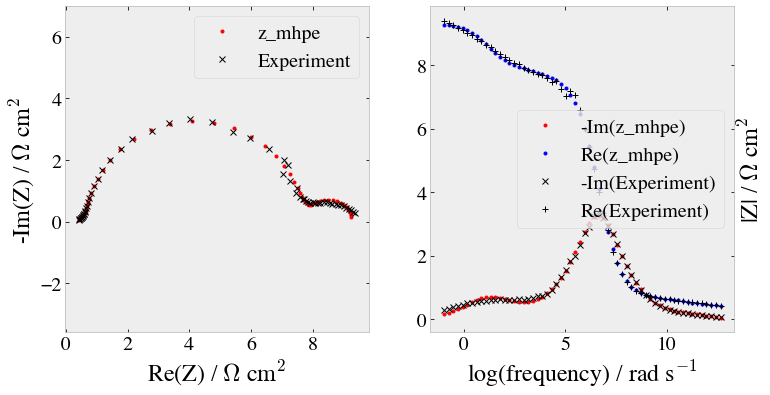

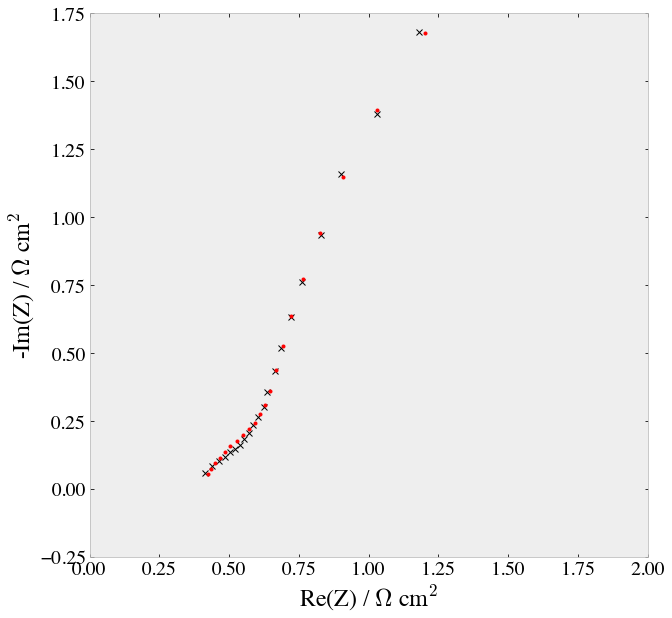

In [102]:
input_dict = {
        'T':303.15,     # Temperature (K)
        'A':5,          # geometric surface area (cm^2)
        'C_R':0.00025,  # concentration of reduced species (mol / L)
        'C_O':0.00025,  # concentration of oxidized species (mol / L)
        'rho1':1.6,     # electrolyte resistivity (ohm cm^-1)
        'rho2':.012,    # solid phase resistivity (ohm cm^-1)
        'b':.3,         # electrode thickness (cm)
        'D_R':1.1e-6,   # Diffusion coefficient for reduced species (cm^2 / s)
        'D_O':0.57e-6,  # Diffusion coefficient for oxidized species (cm^2 / s)
        'C_dl':20e-6,   # Double layer capacitance per unit surface area
        'n':1,          # number of electrons transferred
        'A_t':100,      # Wetted surface area (cm^2)
        'i0':3e-4,      # exchange current density (A cm^2)
        'P':.95,        # CPE exponent (-)
        'ASR_mem':.5,   # membrane ASR (Ohm cm^2)
        'a':.002,       # Nernstian diffusion layer thickness (cm)
        'f':.05,        # scale factor (-)
        'L':1e-7,       # inductance (H)
        'z_model':z_mhpe
        }
floating_params = ['A_t','i0','P','ASR_mem','a','f','L']
# calculating the fitted parameters with z_fit and printing their values
model = cell_response
fit_spectrum = z_fit(   input_dict,
                        ReZ,
                        ImZ,
                        frequency,
                        floating_params,
                        area,
                        model,
                        residual,
                        one_max_keys = ['P'])
# generating a new spectrum with fitted parameters
Z_ = model(fit_spectrum,frequency)
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = fs, num = 7)
z_plot( real(Z_),imag(Z_),
        frequency,
        ax[0],
        ax[1],
        input_dict['z_model'].__name__,
        color = ['r','b'],
        marker = ['.','.'])
z_plot( ReZ*5,-ImZ*5,
        frequency,
        ax[0],
        ax[1],
        'Experiment',
        color = ['k','k'],
        marker = ['x','+'])
plt.savefig('spectrumTest.png',dpi=300)
plt.show()

plt.figure(8, figsize = (10,10))
ax = plt.gca()
spacing = 2
y_min = -.25
x_min = 0
high_frequency_detail(  ReZ*5,ImZ*5, ax, 'experiment',y_min = y_min, 
                        x_min = x_min, spacing = spacing)
high_frequency_detail(  real(Z_),-imag(Z_), ax, 'z_mhpe', color = 'r', 
                        marker = '.', x_min = x_min, y_min = y_min, 
                        spacing = spacing)

## Appendix

[Link to Contents](#Contents)

### Notes on coding style:
  * I have tried to stick to PEP 8 style for function and variable naming as much as possible. 
  * It should be noted that for later versions of python, dictionary
insertion order is preserved so that when the keys are queried, they return in
the same order as they were inserted (not sorted alphabetically, etc.).  For
this reason, [z_fit](#z_fit) can use a list comprehension to extract the values
of inputDict into x0 in the same order they were inserted.  Without this, there
is no guarantee that x0 will correspond to the expected argument that the
respective model is receiving.
  * When a list is unpacked into parameters, passing an underscore is used only to highlight that this parameter is not used in that particular scope.
  * Text folding: the triple curly bracket sets are to mark the text folding. since they are behind the comment symbol ("#") they are not part of the code, but only for the text editor to hide